In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
import matplotlib.patches as mpatches
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
import os
import warnings
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from pyfish import fish_plot, process_data
# local import
from utils import enrichment
from utils import ml_metrics, get_rbd_mutated
from utils import AFFINITY, ESCAPE, MOI

In [3]:
def read_mi(fname, name='all', date=True):
    a = pd.read_csv(fname, sep='\t')

    # filtering
    #
    # 1. end of the genome
    # 2. same gene and same codon
    # 3. different gene and too close
    #
    a = a[((a['pos_source'] <= 29674) & (a['pos_target'] <= 29674)) &
          (((a['gene_source'] == a['gene_target']) &
            (a['feature_codon_source'] != a['feature_codon_target'])) |
           ((a['gene_source'] != a['gene_target'])))]

    a['name'] = name
    if date:
        a['year'] = int(name.split('-')[0])
        a['month'] = int(name.split('-')[1])

    return a

In [4]:
INTERESTING = set(MOI).union(AFFINITY).union(ESCAPE)

In [5]:
print(INTERESTING)

{18, 403, 406, 417, 681, 439, 440, 446, 447, 449, 452, 455, 456, 477, 484, 489, 493, 494, 496, 498, 501, 505, 506}


In [6]:
def plot_mi(s, date):
    c = s[s['name'] == date].pivot_table(index='feature_codon_source',
                                         columns='feature_codon_target',
                                         values='outlier',
                                         aggfunc=max)
    
    c = c.reindex(index=sorted(INTERESTING),
                  columns=sorted(INTERESTING))
    
    cmap = plt.get_cmap('crest_r').copy()
    cmap.set_bad('xkcd:light grey')
    
    colors = []
    for x in c.index:
        if x in AFFINITY:
            colors.append('#ef3b2cff')
        elif x in ESCAPE:
            colors.append('#2171b5ff')
        elif x in MOI:
            colors.append('#fec44fff')
        else:
            colors.append('xkcd:grey')
    
    c.index = c.index.astype(int)
    c.columns = c.columns.astype(int)
    
    cm = sns.clustermap(c, cmap=cmap,
                        row_cluster=False, col_cluster=False,
                        row_colors=colors,
                        col_colors=colors,
                        linewidths=0.005,
                        cbar_pos=None,
                        figsize=(7, 7),
                        vmin=1, vmax=4)
    
    cm.ax_heatmap.set_xlabel('spike codon')
    cm.ax_heatmap.set_ylabel('spike codon')
    
    cm.ax_heatmap.set_xticks([x + 0.5 for x in range(c.shape[1])],
                             c.columns,
                             fontsize=13)
    cm.ax_heatmap.set_yticks([x + 0.5 for x in range(c.shape[0])],
                             c.index,
                             fontsize=13)
    
    cm.ax_heatmap.set_title(date, y=1.04)
    
    plt.savefig(f'time_{date}.png',
                dpi=300,
                bbox_inches='tight',
                transparent=True)
    plt.savefig(f'time_{date}.svg',
                dpi=300,
                bbox_inches='tight',
                transparent=True);

In [7]:
a = read_mi(f'../out/all-notime/mi_annotated.tsv.gz',
            'all', date=False)

In [8]:
no_time = read_mi(f'../out/time-subsets-notime/2023-03/mi_annotated.tsv.gz',
                  '2023-03',
                  date=True)

In [9]:
df = []
d_mutated = {}
all_mutated = set()
for name in sorted(os.listdir('../out/time-filtered-subsets/')):
    try:
        df.append(read_mi(f'../out/time-filtered-subsets/{name}/mi_annotated.tsv.gz',
                          name,
                          date=True))
        mutated = get_rbd_mutated('../out/time-filtered-lineages/',
                                  names=[name,])
        d_mutated[name] = mutated.union(all_mutated)
        all_mutated = mutated.union(all_mutated)
    except FileNotFoundError:
        pass
df = pd.concat(df)

In [10]:
df.groupby(['year', 'month'])['pos_source'].count()

year  month
2020  3        90632
      4        85538
      5        76758
      6        81874
      7        65820
      8        57754
      9        51230
      10       46484
      11       30098
      12       25134
2021  1        25754
      2        16362
      3        13766
      4        13670
      5        15222
      6        12960
      7        11410
      8        10088
      9         9866
      10       13578
      11       10668
      12        8270
2022  1         8884
      2         6990
      3         6086
      4         3904
      5         2912
      6         2834
      7         2710
      8         2666
      9         2732
      10        2880
      11        3308
      12        2680
2023  1         3268
      2         3648
      3         4484
Name: pos_source, dtype: int64

In [11]:
count = df.groupby(['name', 'outlier'])['pos_source'].count().reset_index()

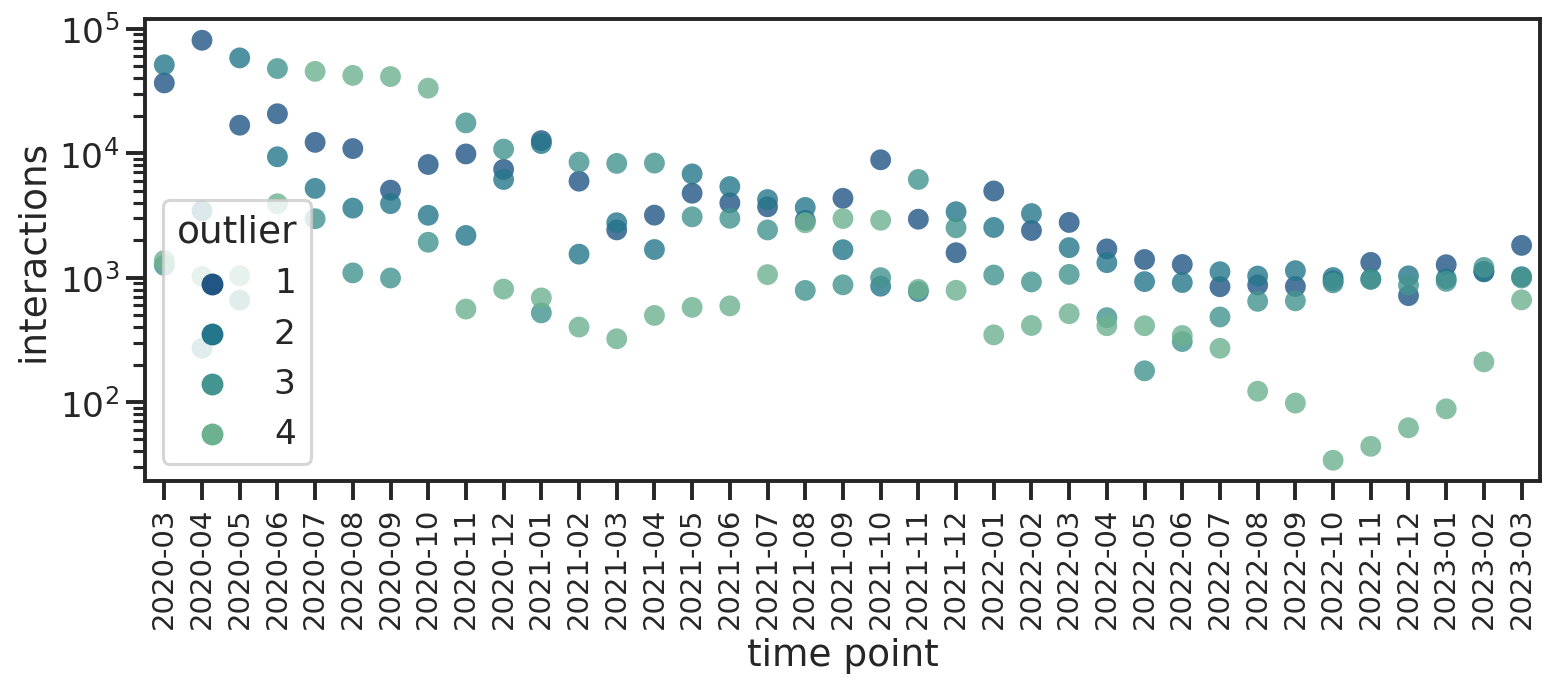

In [12]:
plt.figure(figsize=(12, 4))

sns.stripplot(data=count,
              y='pos_source',
              x='name',
              hue='outlier',
              size=10,
              jitter=0,
              alpha=0.8,
              palette=sns.color_palette('crest_r', 4))

plt.xticks(rotation=90,
           size=14)

plt.legend(facecolor='w',
           title='outlier')

plt.ylabel('interactions')
plt.xlabel('time point')

plt.yscale('log')

# plt.savefig('time_1.png',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True)
# plt.savefig('time_1.svg',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True);

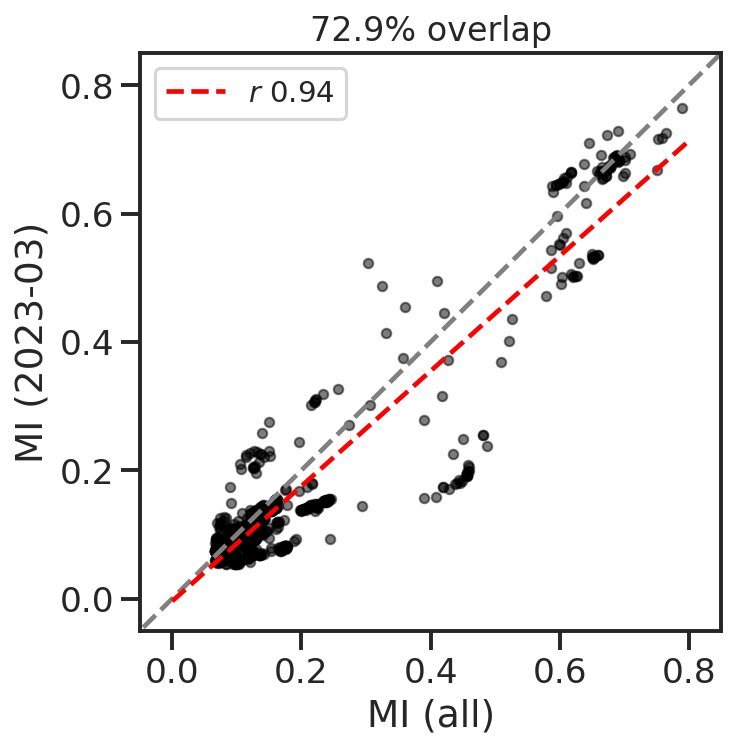

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

a = a.set_index(['pos_source', 'pos_target'])
no_time = no_time.set_index(['pos_source', 'pos_target'])

idx = a.index.intersection(no_time.index)

av = a.loc[idx]['mi']
sv = no_time.loc[idx]['mi']

ax.plot(av,
        sv,
        'k.',
        alpha=0.3,
        rasterized=True)
ax.plot([-1, 1], [-1, 1],
        '--',
        color='grey')

lr = stats.linregress(av, sv)

ax.plot([0, 0.8],
        [lr.intercept,
         lr.slope * 0.8 + lr.intercept],
        'r--',
        label=f'$r$ {lr.rvalue:.2f}')

ax.legend(facecolor='w', fontsize=14)

ax.set_xlim(-0.05, 0.85)
ax.set_ylim(-0.05, 0.85)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

ax.set_ylabel('MI (2023-03)')
ax.set_xlabel('MI (all)')

ax.set_title(f'{av.shape[0] * 100 / a.shape[0]:.1f}% overlap',
             fontsize=16)

a = a.reset_index()
no_time = no_time.reset_index()

# plt.savefig('time_2.png',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True)
# plt.savefig('time_2.svg',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True);

In [14]:
p = pd.read_csv('../out/spikes/2023-03/2023-03.EC', sep=' ', header=None)
p.columns = ['pos_source', 'base_source',
             'pos_target', 'base_target',
             '_', 'plmc']

In [15]:
m = no_time[(no_time['gene_source'] == 'S') &
            (no_time['gene_target'] == 'S')].sort_values('pos_source').copy()
m['pos_source'] = m['pos_source'] - 21562
m['pos_target'] = m['pos_target'] - 21562

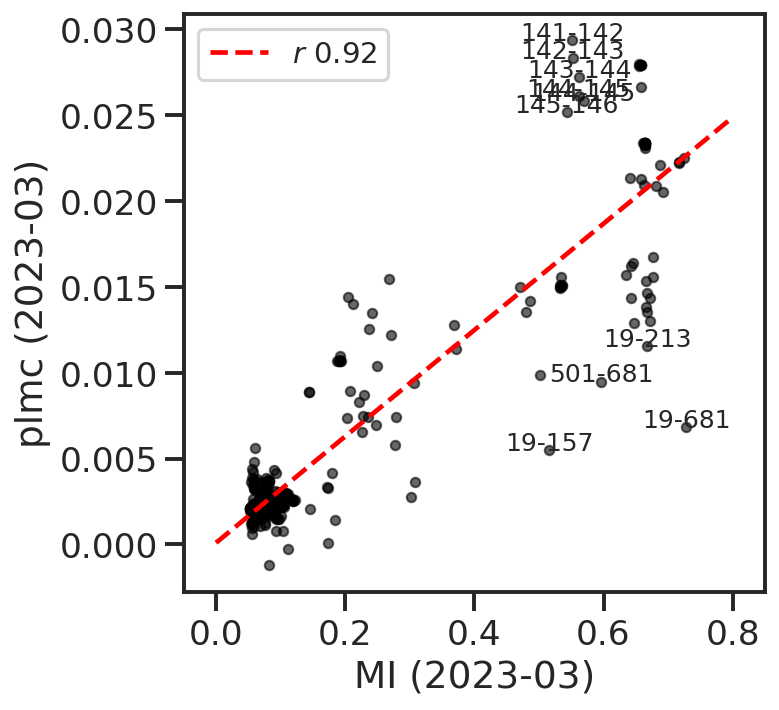

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

m = m.set_index(['pos_source', 'pos_target'])
p = p.set_index(['pos_source', 'pos_target'])

idx = m.index.intersection(p.index)

av = m.loc[idx]['mi']
sv = p.loc[idx]['plmc']

ax.plot(av,
        sv,
        'k.',
        alpha=0.6,
        rasterized=True)


lr = stats.linregress(av, sv)

ax.plot([0, 0.8],
        [lr.intercept,
         lr.slope * 0.8 + lr.intercept],
        'r--',
        label=f'$r$ {lr.rvalue:.2f}')

res = m.loc[idx].join(p.loc[idx], how='inner')
res['res'] = res['plmc'] - (lr.slope * res['mi'] + lr.intercept)
res['abs(res)'] = abs(res['res'])
res = res.sort_values('abs(res)').tail(10)
for p1, p2, mi, plmc in res[['feature_codon_source',
                             'feature_codon_target',
                             'mi', 'plmc']].values:
    ax.text(mi, plmc,
            f'{int(p1)}-{int(p2)}',
            size=12,
            ha='center')

ax.legend(facecolor='w', fontsize=14)
ax.set_xlim(-0.05, 0.85)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])

ax.set_ylabel('plmc (2023-03)')
ax.set_xlabel('MI (2023-03)')

a = m.reset_index()
m = m.reset_index()
p = p.reset_index()

# plt.savefig('time_3.png',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True)
# plt.savefig('time_3.svg',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True);

In [17]:
res = []
for name in sorted(df['name'].unique()):
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])
    
    s = df[df['name'] == name]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        o = enrichment(s, d_mutated[name])
    
    print(name)

    res.append(['actual', year, month, name,
                o[o['type'] == 'original']['odds-ratio'].values[0],
                o[o['type'] == 'original']['low'].values[0],
                o[o['type'] == 'original']['high'].values[0]])

    for odds_ratio in o[o['type'] == 'random']['odds-ratio'].values:
        res.append(['random', year, month, name, odds_ratio + 0.1, np.nan, np.nan])

r = pd.DataFrame(res,
                 columns=['set',
                          'year', 'month',
                          'name', 'odds-ratio',
                          'low', 'high'])
r.groupby(['name', 'year', 'month', 'set']).mean().to_csv('enrichment_time.tsv',
                                                          sep='\t')

2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


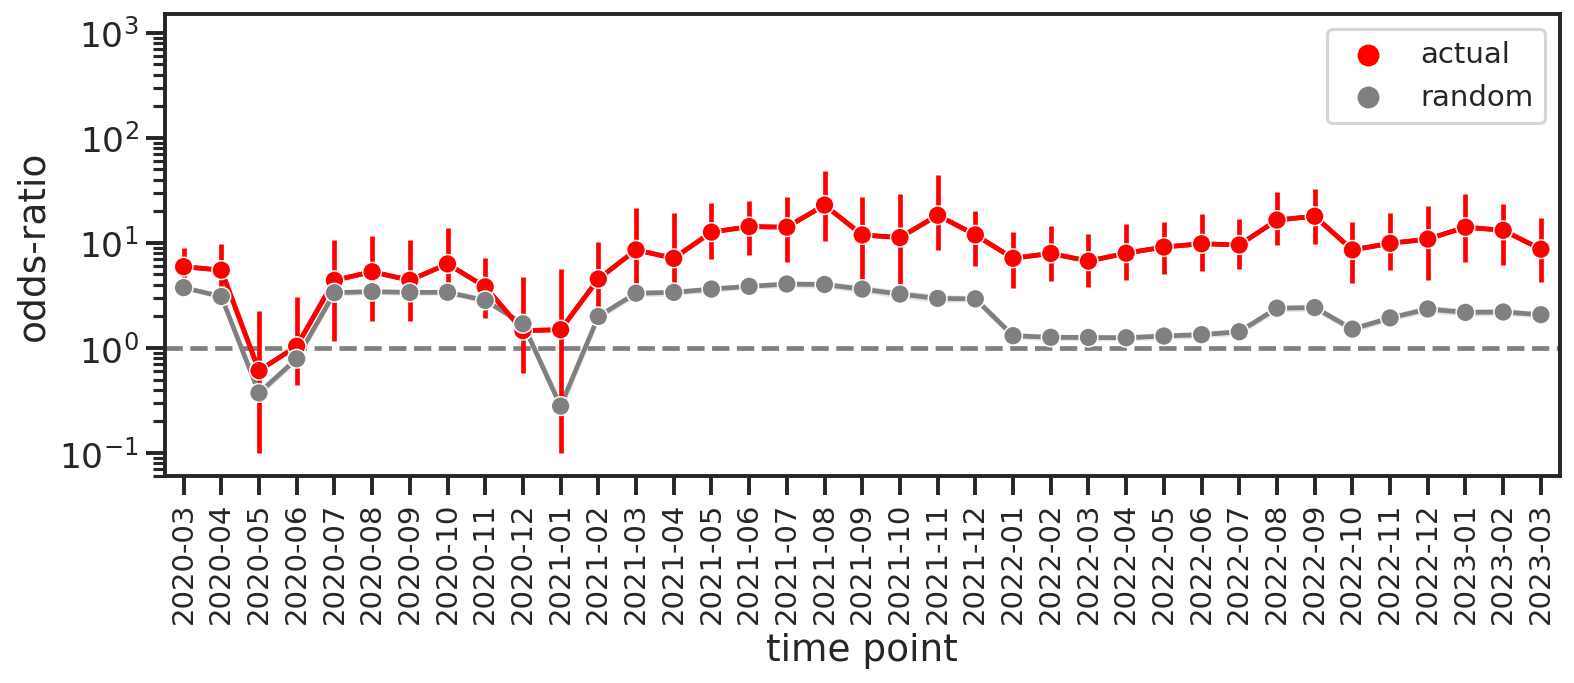

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=r,
             x='name',
             y='odds-ratio',
             hue='set',
             errorbar='ci',
             ax=ax,
             legend=False,
             palette=['r', 'grey'])
plt.errorbar(range(r['name'].unique().shape[0]),
             r[r['set'] == 'actual']['odds-ratio'],
             yerr=abs(r[r['set'] == 'actual'][['low', 'high']].T.values -
                      r[r['set'] == 'actual']['odds-ratio'].values + 0.1),
             color='r')
sns.scatterplot(data=r.groupby(['name', 'set'])[['odds-ratio']].mean().reset_index(),
                x='name',
                y='odds-ratio',
                hue='set',
                ax=ax,
                palette=['r', 'grey'],
                zorder=10)

plt.axhline(1,
            color='grey', ls='dashed', zorder=-1)

plt.legend(facecolor='w', fontsize=14)

plt.xticks(rotation=90,
           fontsize=14)
plt.xlabel('time point')

plt.xlim(-0.5, r['name'].unique().shape[0] - 0.5)

plt.ylim(0.06, 1500)

plt.yscale('log')

# plt.savefig('time_4.png',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True)
# plt.savefig('time_4.svg',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True);

In [19]:
res = []
for name in sorted(df['name'].unique()):
    print(name)
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])
    
    s = df[df['name'] == name]

    ml = ml_metrics(s,
                    mutated=d_mutated[name],
                    shuffle=False)
    ml['name'] = name
    ml['set'] = 'actual'
    res.append(ml)

    # for i in range(100):
    #     with warnings.catch_warnings():
    #         warnings.simplefilter("ignore")
    #         ml = ml_metrics(s,
    #                         mutated=d_mutated[name],
    #                         shuffle=True)
    #         ml['name'] = name
    #         ml['set'] = 'random'
    #         res.append(ml)

m = pd.concat(res)

2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


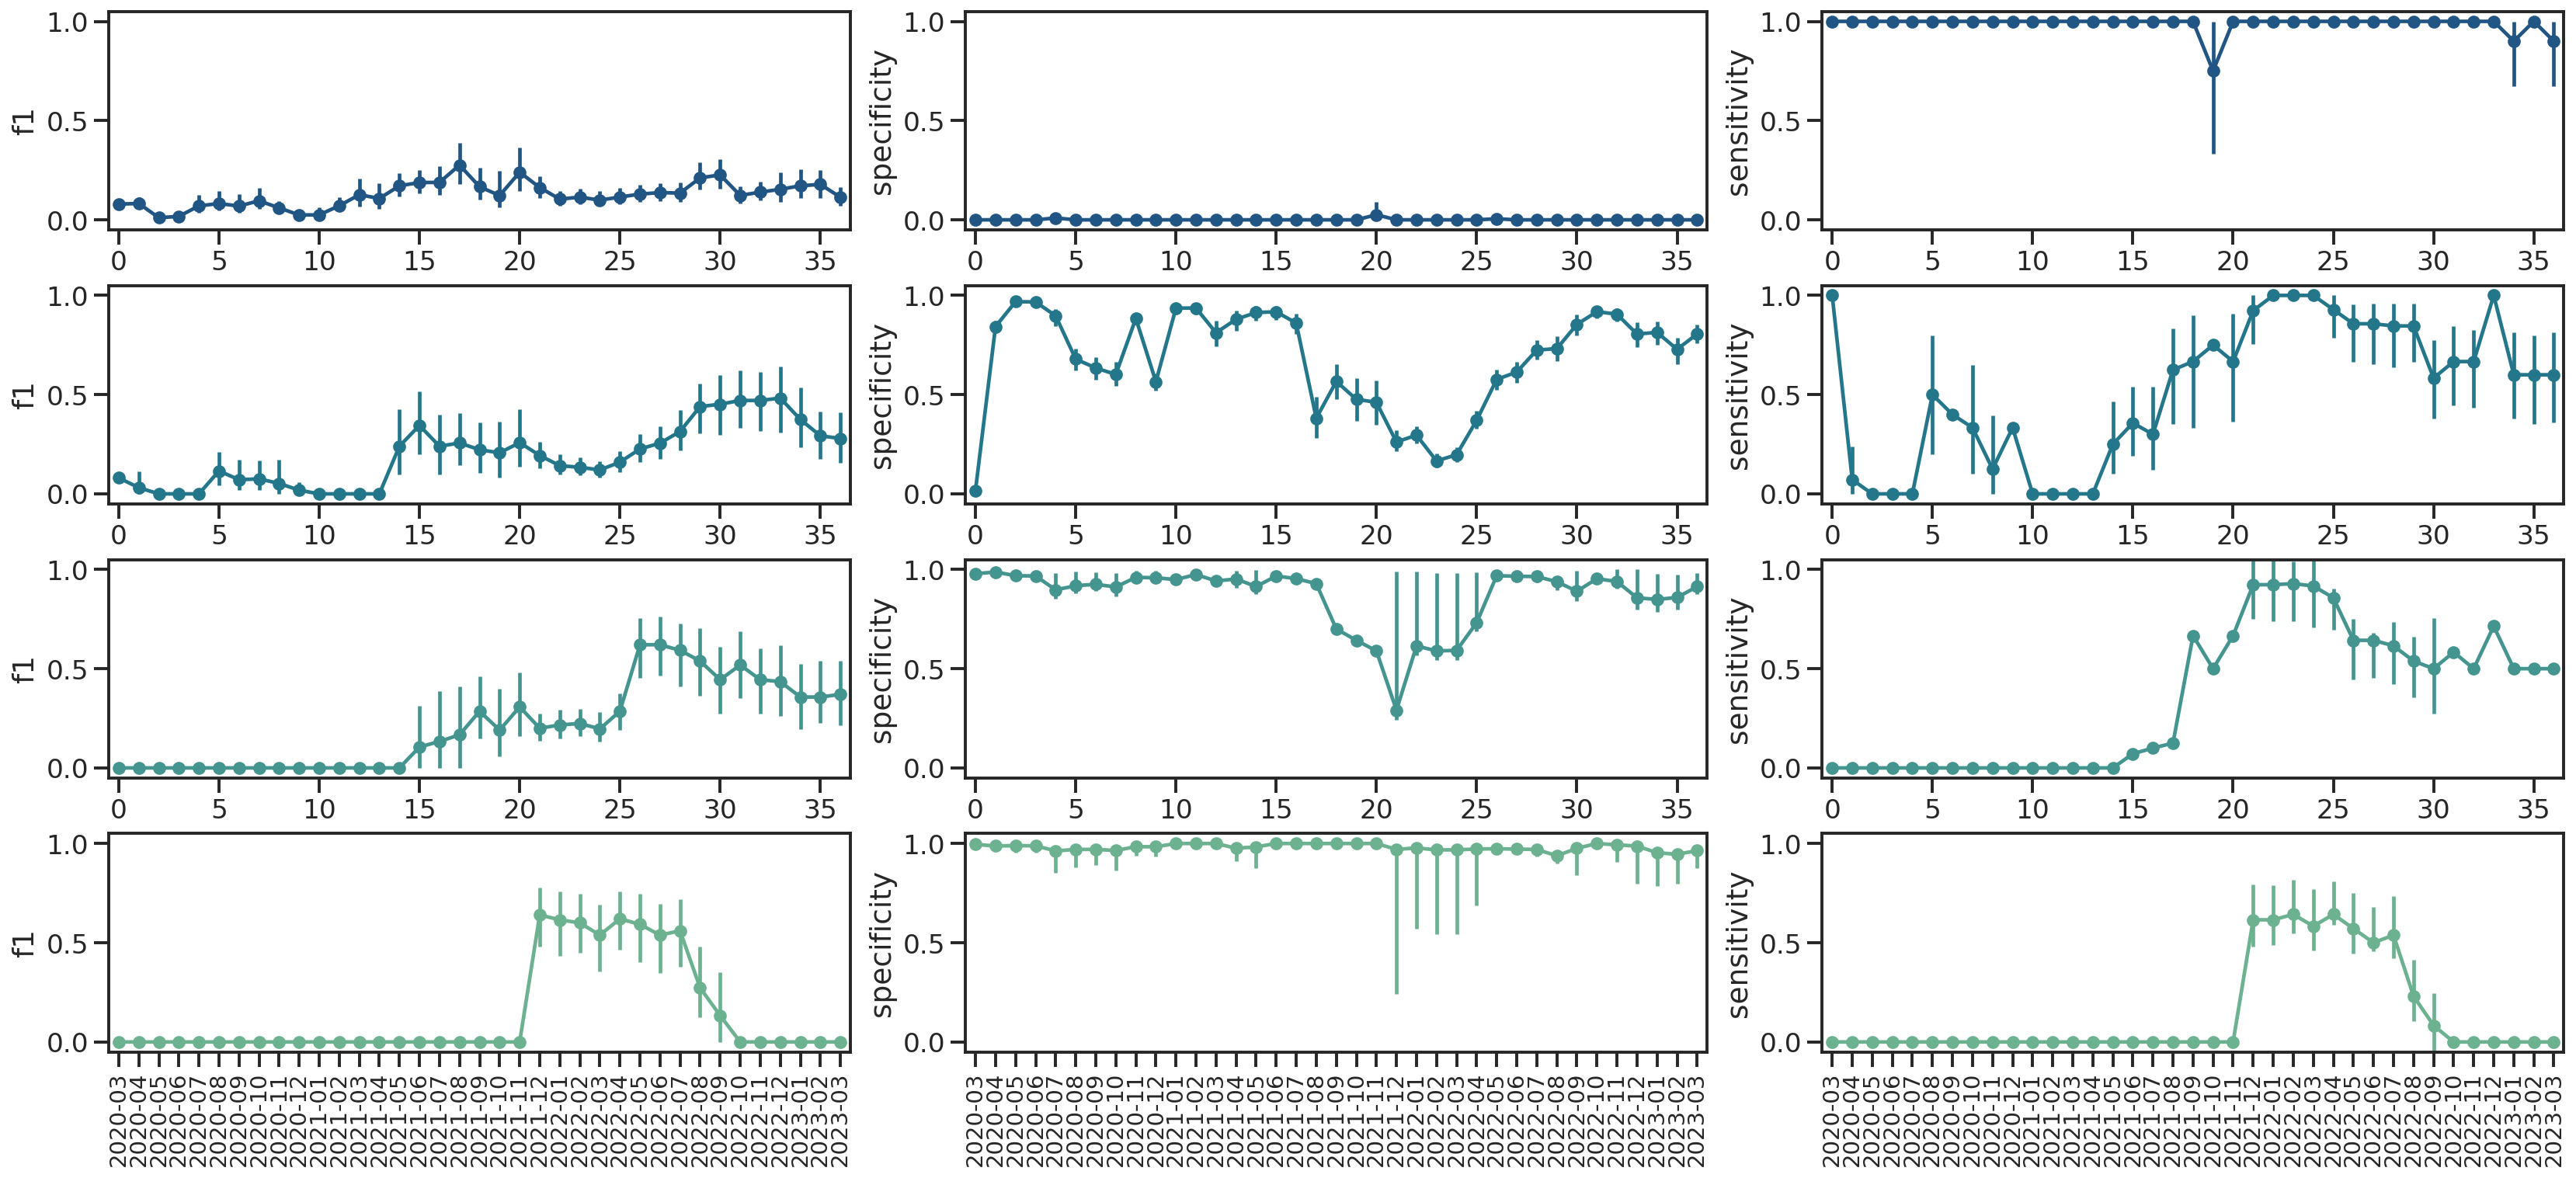

In [20]:
fig, axes = plt.subplots(4, 3, figsize=(22, 10),
                         constrained_layout=True)

for col, metric in zip(range(3),
                       ('f1', 'specificity', 'sensitivity')):
    for row, ol, color in zip(range(4), range(1, 5),
                              sns.color_palette('crest_r', 4)):
        ax = axes[row][col]
        t = m[(m['metric'] == metric) &
              (m['outlier'] == ol)]
        ax.errorbar(range(t['name'].unique().shape[0]),
                    t[t['set'] == 'actual']['value'],
                    yerr=abs(t[t['set'] == 'actual'][['low', 'high']].T.values -
                             t[t['set'] == 'actual']['value'].values),
                    color=color, zorder=-1, fmt='o-',
                    markersize=7)
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel(metric)
        ax.set_xlim(-0.5, m['name'].unique().shape[0] - 0.5)
        if row == 3:
            ax.set_xticks(range(m['name'].unique().shape[0]),
                          labels=m['name'].unique(),
                          rotation=90,
                          fontsize=14)

# plt.savefig('time_5.png',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True)
# plt.savefig('time_5.svg',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True);

In [21]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 1)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.079365
2020-04  actual    0.082353
2020-05  actual    0.010444
2020-06  actual    0.017595
2020-07  actual    0.070175
2020-08  actual    0.082192
2020-09  actual    0.069444
2020-10  actual    0.096000
2020-11  actual    0.060150
2020-12  actual    0.024490
2021-01  actual    0.025000
2021-02  actual    0.071006
2021-03  actual    0.126582
2021-04  actual    0.107527
2021-05  actual    0.171429
2021-06  actual    0.187919
2021-07  actual    0.188679
2021-08  actual    0.275862
2021-09  actual    0.166667
2021-10  actual    0.122449
2021-11  actual    0.240000
2021-12  actual    0.162500
2022-01  actual    0.104418
2022-02  actual    0.114286
2022-03  actual    0.099174
2022-04  actual    0.114754
2022-05  actual    0.129630
2022-06  actual    0.137255
2022-07  actual    0.134715
2022-08  actual    0.211382
2022-09  actual    0.226415
2022-10  actual    0.123077
2022-11  actual    0.139535
2022-12  actual    0.153846
2023-01  actual    0.171429
2023

In [22]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 2)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.080645
2020-04  actual    0.031250
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.115385
2020-09  actual    0.071429
2020-10  actual    0.075472
2020-11  actual    0.052632
2020-12  actual    0.018519
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.000000
2021-05  actual    0.240000
2021-06  actual    0.344828
2021-07  actual    0.240000
2021-08  actual    0.256410
2021-09  actual    0.222222
2021-10  actual    0.206897
2021-11  actual    0.258065
2021-12  actual    0.193548
2022-01  actual    0.142077
2022-02  actual    0.133971
2022-03  actual    0.120603
2022-04  actual    0.159509
2022-05  actual    0.226415
2022-06  actual    0.255319
2022-07  actual    0.314286
2022-08  actual    0.440000
2022-09  actual    0.451613
2022-10  actual    0.470588
2022-11  actual    0.470588
2022-12  actual    0.482759
2023-01  actual    0.375000
2023

In [23]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 3)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.000000
2020-04  actual    0.000000
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.000000
2020-09  actual    0.000000
2020-10  actual    0.000000
2020-11  actual    0.000000
2020-12  actual    0.000000
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.000000
2021-05  actual    0.000000
2021-06  actual    0.105263
2021-07  actual    0.133333
2021-08  actual    0.166667
2021-09  actual    0.285714
2021-10  actual    0.190476
2021-11  actual    0.307692
2021-12  actual    0.200000
2022-01  actual    0.216216
2022-02  actual    0.224138
2022-03  actual    0.196429
2022-04  actual    0.285714
2022-05  actual    0.620690
2022-06  actual    0.620690
2022-07  actual    0.592593
2022-08  actual    0.538462
2022-09  actual    0.444444
2022-10  actual    0.518519
2022-11  actual    0.444444
2022-12  actual    0.434783
2023-01  actual    0.357143
2023

In [24]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 4)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.000000
2020-04  actual    0.000000
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.000000
2020-09  actual    0.000000
2020-10  actual    0.000000
2020-11  actual    0.000000
2020-12  actual    0.000000
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.000000
2021-05  actual    0.000000
2021-06  actual    0.000000
2021-07  actual    0.000000
2021-08  actual    0.000000
2021-09  actual    0.000000
2021-10  actual    0.000000
2021-11  actual    0.000000
2021-12  actual    0.640000
2022-01  actual    0.615385
2022-02  actual    0.600000
2022-03  actual    0.538462
2022-04  actual    0.620690
2022-05  actual    0.592593
2022-06  actual    0.538462
2022-07  actual    0.560000
2022-08  actual    0.272727
2022-09  actual    0.133333
2022-10  actual    0.000000
2022-11  actual    0.000000
2022-12  actual    0.000000
2023-01  actual    0.000000
2023

In [25]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 1)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.000000
2020-04  actual    0.000000
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.009346
2020-08  actual    0.000000
2020-09  actual    0.000000
2020-10  actual    0.000000
2020-11  actual    0.000000
2020-12  actual    0.000000
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.000000
2021-05  actual    0.000000
2021-06  actual    0.000000
2021-07  actual    0.000000
2021-08  actual    0.000000
2021-09  actual    0.000000
2021-10  actual    0.000000
2021-11  actual    0.025641
2021-12  actual    0.000000
2022-01  actual    0.000000
2022-02  actual    0.000000
2022-03  actual    0.000000
2022-04  actual    0.000000
2022-05  actual    0.005291
2022-06  actual    0.000000
2022-07  actual    0.000000
2022-08  actual    0.000000
2022-09  actual    0.000000
2022-10  actual    0.000000
2022-11  actual    0.000000
2022-12  actual    0.000000
2023-01  actual    0.000000
2023

In [26]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 2)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.017241
2020-04  actual    0.842949
2020-05  actual    0.968338
2020-06  actual    0.967164
2020-07  actual    0.897196
2020-08  actual    0.679104
2020-09  actual    0.634328
2020-10  actual    0.601770
2020-11  actual    0.884000
2020-12  actual    0.564854
2021-01  actual    0.935897
2021-02  actual    0.936306
2021-03  actual    0.811594
2021-04  actual    0.879518
2021-05  actual    0.913793
2021-06  actual    0.917355
2021-07  actual    0.860465
2021-08  actual    0.380952
2021-09  actual    0.566667
2021-10  actual    0.476190
2021-11  actual    0.461538
2021-12  actual    0.261194
2022-01  actual    0.295964
2022-02  actual    0.165899
2022-03  actual    0.197248
2022-04  actual    0.370370
2022-05  actual    0.576720
2022-06  actual    0.613636
2022-07  actual    0.724551
2022-08  actual    0.731959
2022-09  actual    0.853659
2022-10  actual    0.918129
2022-11  actual    0.905405
2022-12  actual    0.805195
2023-01  actual    0.813953
2023

In [27]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 3)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.978448
2020-04  actual    0.987179
2020-05  actual    0.968338
2020-06  actual    0.967164
2020-07  actual    0.897196
2020-08  actual    0.917910
2020-09  actual    0.925373
2020-10  actual    0.911504
2020-11  actual    0.960000
2020-12  actual    0.958159
2021-01  actual    0.948718
2021-02  actual    0.974522
2021-03  actual    0.942029
2021-04  actual    0.951807
2021-05  actual    0.913793
2021-06  actual    0.966942
2021-07  actual    0.953488
2021-08  actual    0.928571
2021-09  actual    0.700000
2021-10  actual    0.642857
2021-11  actual    0.589744
2021-12  actual    0.291045
2022-01  actual    0.614350
2022-02  actual    0.589862
2022-03  actual    0.591743
2022-04  actual    0.731481
2022-05  actual    0.968254
2022-06  actual    0.965909
2022-07  actual    0.964072
2022-08  actual    0.938144
2022-09  actual    0.890244
2022-10  actual    0.953216
2022-11  actual    0.939189
2022-12  actual    0.857143
2023-01  actual    0.848837
2023

In [28]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 4)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.995690
2020-04  actual    0.987179
2020-05  actual    0.989446
2020-06  actual    0.988060
2020-07  actual    0.962617
2020-08  actual    0.970149
2020-09  actual    0.970149
2020-10  actual    0.964602
2020-11  actual    0.984000
2020-12  actual    0.983264
2021-01  actual    1.000000
2021-02  actual    1.000000
2021-03  actual    1.000000
2021-04  actual    0.975904
2021-05  actual    0.982759
2021-06  actual    1.000000
2021-07  actual    1.000000
2021-08  actual    1.000000
2021-09  actual    1.000000
2021-10  actual    1.000000
2021-11  actual    1.000000
2021-12  actual    0.970149
2022-01  actual    0.977578
2022-02  actual    0.967742
2022-03  actual    0.967890
2022-04  actual    0.972222
2022-05  actual    0.973545
2022-06  actual    0.971591
2022-07  actual    0.970060
2022-08  actual    0.938144
2022-09  actual    0.975610
2022-10  actual    1.000000
2022-11  actual    0.993243
2022-12  actual    0.987013
2023-01  actual    0.953488
2023

In [29]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 1)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    1.00
2020-04  actual    1.00
2020-05  actual    1.00
2020-06  actual    1.00
2020-07  actual    1.00
2020-08  actual    1.00
2020-09  actual    1.00
2020-10  actual    1.00
2020-11  actual    1.00
2020-12  actual    1.00
2021-01  actual    1.00
2021-02  actual    1.00
2021-03  actual    1.00
2021-04  actual    1.00
2021-05  actual    1.00
2021-06  actual    1.00
2021-07  actual    1.00
2021-08  actual    1.00
2021-09  actual    1.00
2021-10  actual    0.75
2021-11  actual    1.00
2021-12  actual    1.00
2022-01  actual    1.00
2022-02  actual    1.00
2022-03  actual    1.00
2022-04  actual    1.00
2022-05  actual    1.00
2022-06  actual    1.00
2022-07  actual    1.00
2022-08  actual    1.00
2022-09  actual    1.00
2022-10  actual    1.00
2022-11  actual    1.00
2022-12  actual    1.00
2023-01  actual    0.90
2023-02  actual    1.00
2023-03  actual    0.90
Name: value, dtype: float64

In [30]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 2)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    1.000000
2020-04  actual    0.071429
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.500000
2020-09  actual    0.400000
2020-10  actual    0.333333
2020-11  actual    0.125000
2020-12  actual    0.333333
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.000000
2021-05  actual    0.250000
2021-06  actual    0.357143
2021-07  actual    0.300000
2021-08  actual    0.625000
2021-09  actual    0.666667
2021-10  actual    0.750000
2021-11  actual    0.666667
2021-12  actual    0.923077
2022-01  actual    1.000000
2022-02  actual    1.000000
2022-03  actual    1.000000
2022-04  actual    0.928571
2022-05  actual    0.857143
2022-06  actual    0.857143
2022-07  actual    0.846154
2022-08  actual    0.846154
2022-09  actual    0.583333
2022-10  actual    0.666667
2022-11  actual    0.666667
2022-12  actual    1.000000
2023-01  actual    0.600000
2023

In [31]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 3)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.000000
2020-04  actual    0.000000
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.000000
2020-09  actual    0.000000
2020-10  actual    0.000000
2020-11  actual    0.000000
2020-12  actual    0.000000
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.000000
2021-05  actual    0.000000
2021-06  actual    0.071429
2021-07  actual    0.100000
2021-08  actual    0.125000
2021-09  actual    0.666667
2021-10  actual    0.500000
2021-11  actual    0.666667
2021-12  actual    0.923077
2022-01  actual    0.923077
2022-02  actual    0.928571
2022-03  actual    0.916667
2022-04  actual    0.857143
2022-05  actual    0.642857
2022-06  actual    0.642857
2022-07  actual    0.615385
2022-08  actual    0.538462
2022-09  actual    0.500000
2022-10  actual    0.583333
2022-11  actual    0.500000
2022-12  actual    0.714286
2023-01  actual    0.500000
2023

In [32]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 4)].groupby(['name', 'set'])['value'].max()

name     set   
2020-03  actual    0.000000
2020-04  actual    0.000000
2020-05  actual    0.000000
2020-06  actual    0.000000
2020-07  actual    0.000000
2020-08  actual    0.000000
2020-09  actual    0.000000
2020-10  actual    0.000000
2020-11  actual    0.000000
2020-12  actual    0.000000
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.000000
2021-05  actual    0.000000
2021-06  actual    0.000000
2021-07  actual    0.000000
2021-08  actual    0.000000
2021-09  actual    0.000000
2021-10  actual    0.000000
2021-11  actual    0.000000
2021-12  actual    0.615385
2022-01  actual    0.615385
2022-02  actual    0.642857
2022-03  actual    0.583333
2022-04  actual    0.642857
2022-05  actual    0.571429
2022-06  actual    0.500000
2022-07  actual    0.538462
2022-08  actual    0.230769
2022-09  actual    0.083333
2022-10  actual    0.000000
2022-11  actual    0.000000
2022-12  actual    0.000000
2023-01  actual    0.000000
2023

In [33]:
dist = df.groupby(['name', 'outlier'])['distance'].mean().reset_index()

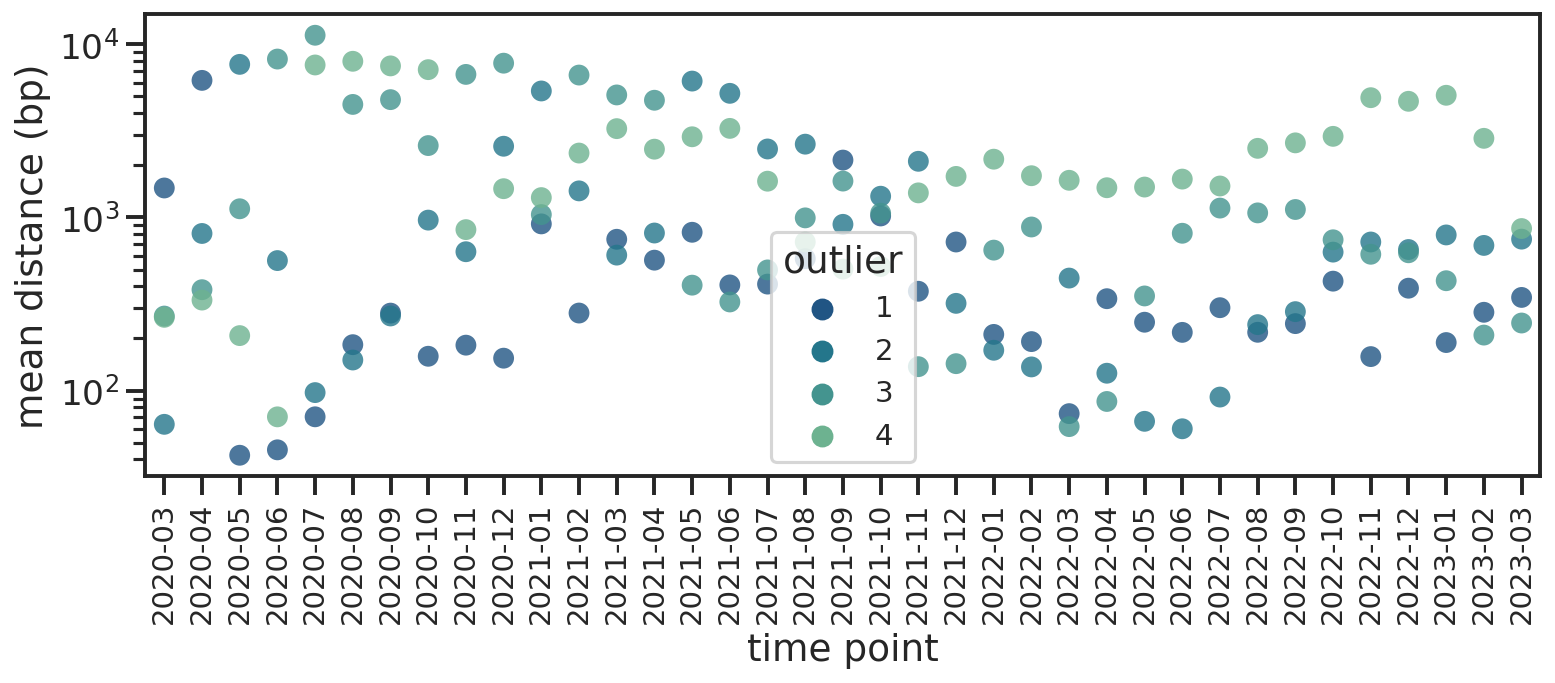

In [34]:
plt.figure(figsize=(12, 4))

sns.stripplot(data=dist,
              y='distance',
              x='name',
              hue='outlier',
              size=10,
              jitter=0,
              alpha=0.8,
              palette=sns.color_palette('crest_r', 4))

plt.xticks(rotation=90,
           size=14)

plt.legend(facecolor='w',
           title='outlier',
           fontsize=14)

plt.ylabel('mean distance (bp)')
plt.xlabel('time point')

plt.yscale('log')

# plt.savefig('time_6.png',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True)
# plt.savefig('time_6.svg',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True);

In [35]:
dist = df.groupby(['name', 'outlier'])['distance'].median().reset_index()

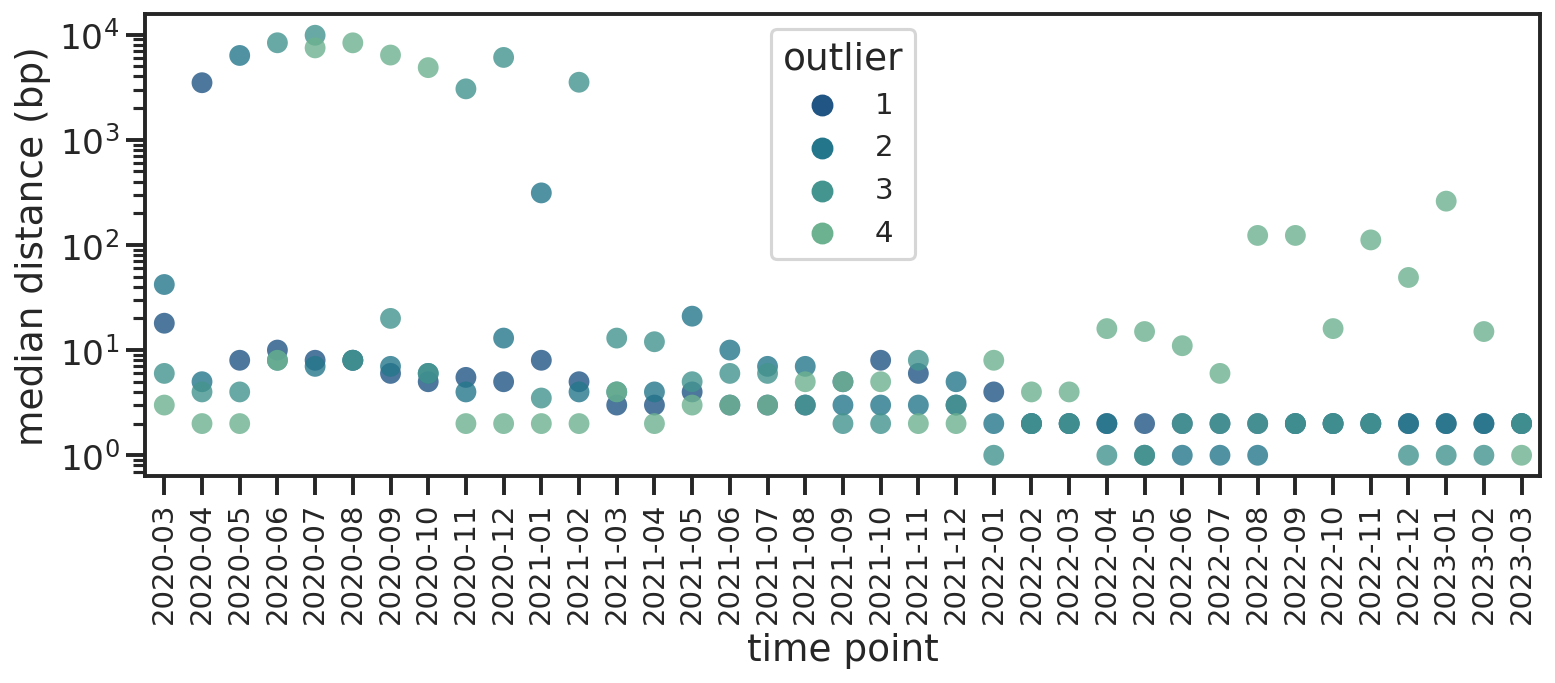

In [36]:
plt.figure(figsize=(12, 4))

sns.stripplot(data=dist,
              y='distance',
              x='name',
              hue='outlier',
              size=10,
              jitter=0,
              alpha=0.8,
              palette=sns.color_palette('crest_r', 4))

plt.xticks(rotation=90,
           size=14)

plt.legend(facecolor='w',
           title='outlier',
           fontsize=14)

plt.ylabel('median distance (bp)')
plt.xlabel('time point')

plt.yscale('log')

# plt.savefig('time_7.png',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True)
# plt.savefig('time_7.svg',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True);

In [37]:
s1 = df[(~df['name'].isin(['2020-02',
                           # '2020-03'
                          ])) &
        (df['gene_source'] == 'S') &
        (df['gene_target'] == 'S') &
        ((df['feature_codon_source'] == 501) &
         (df['feature_codon_target'] == 498))].copy()

s1 = s1.pivot_table(index=['feature_codon_source',
                          'feature_codon_target'],
                   columns='name',
                   values='outlier',
                   aggfunc=max).reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            # '2020-03'
                                                                           ])]['name'].unique()))

In [38]:
s2 = df[(~df['name'].isin(['2020-02',
                           # '2020-03'
                          ])) &
        (df['gene_source'] == 'S') &
        (df['gene_target'] == 'S') &
        ((df['feature_codon_source'].isin(AFFINITY)) &
         (df['feature_codon_target'].isin(INTERESTING.difference(AFFINITY))))].copy()

s2 = s2.pivot_table(index=['feature_codon_source',
                          'feature_codon_target'],
                   columns='name',
                   values='outlier',
                   aggfunc=max).reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            # '2020-03'
                                                                           ])]['name'].unique()))

In [39]:
s3 = df[(~df['name'].isin(['2020-02',
                           # '2020-03'
                          ])) &
        (df['gene_source'] == 'S') &
        (df['gene_target'] == 'S') &
        ((df['feature_codon_source'].isin(INTERESTING.difference(AFFINITY))) &
         (df['feature_codon_target'].isin(INTERESTING.difference(AFFINITY))))].copy()

s3 = s3.pivot_table(index=['feature_codon_source',
                          'feature_codon_target'],
                   columns='name',
                   values='outlier',
                   aggfunc=max).reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            # '2020-03'
                                                                           ])]['name'].unique()))

In [40]:
s = pd.concat([s1, s2])

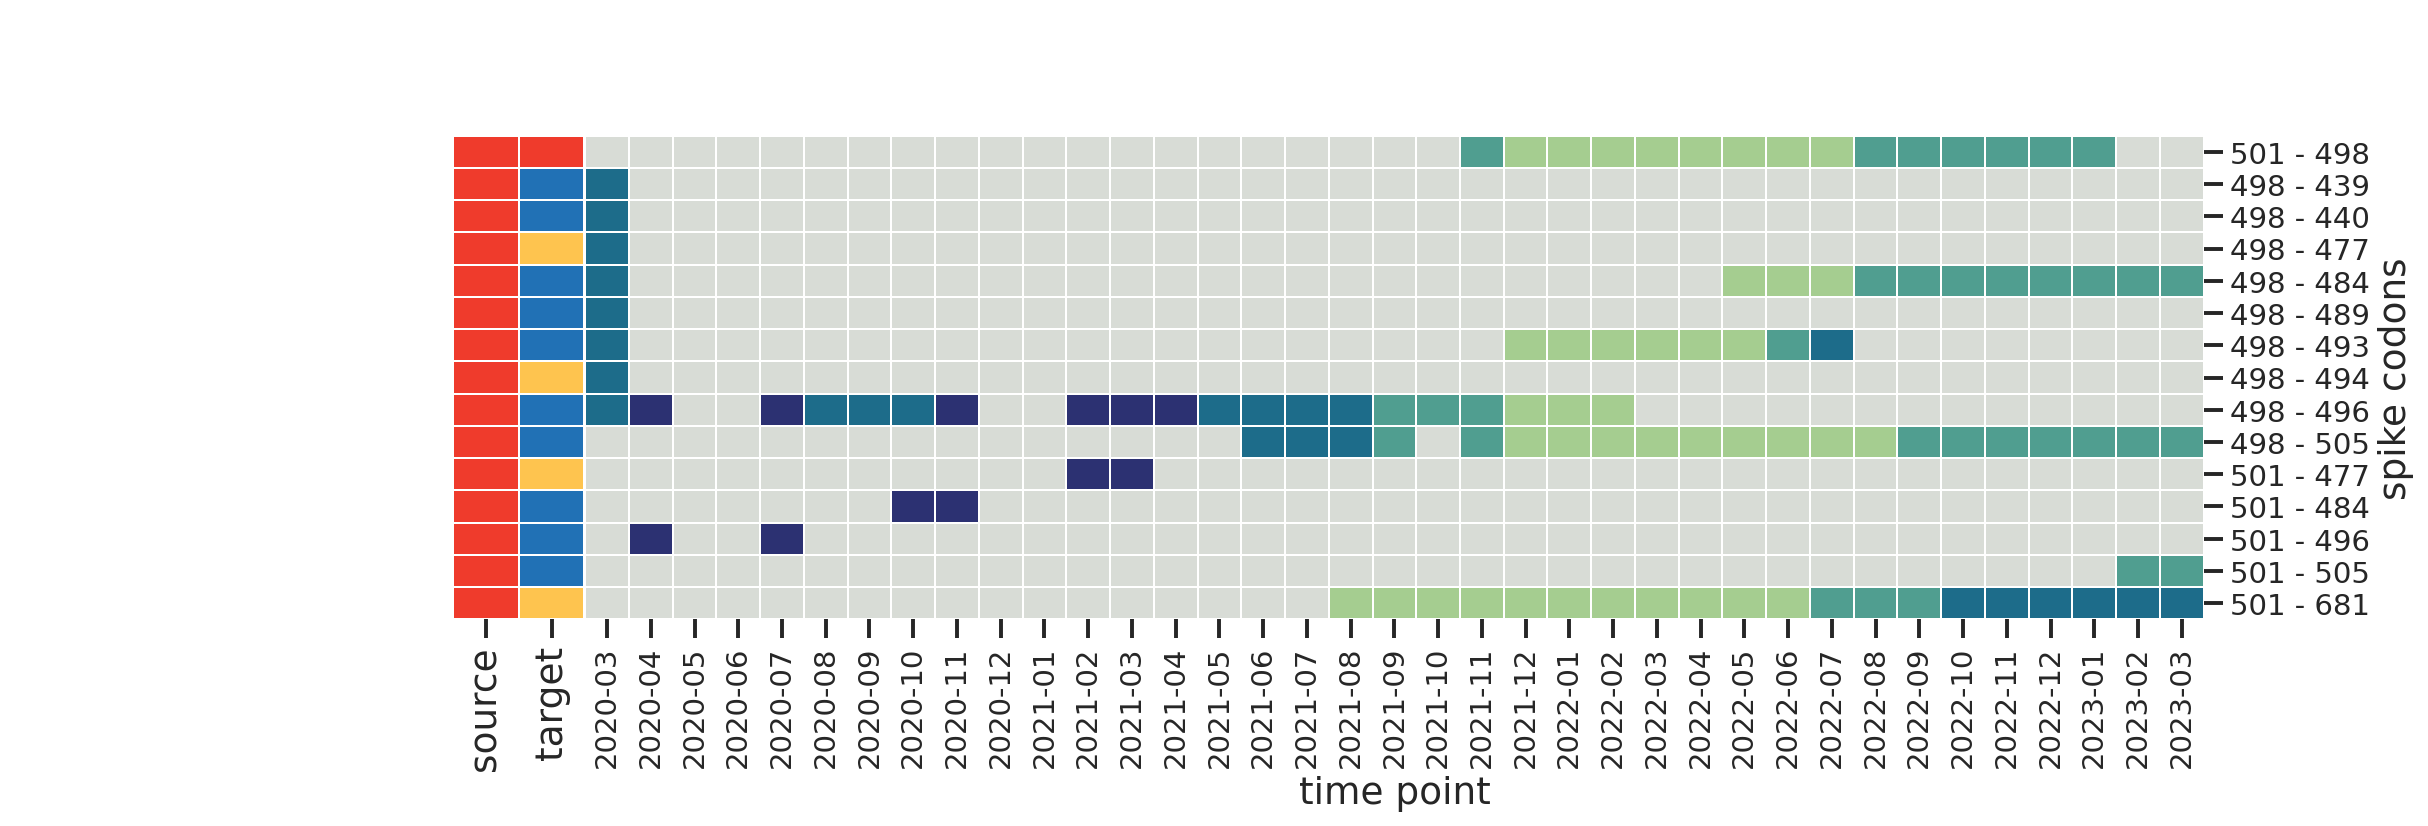

In [41]:
cmap = plt.get_cmap('crest_r').copy()
cmap.set_bad('xkcd:light grey')

colors1 = []
colors2 = []
for x, y in s.index:
    if x in AFFINITY:
        colors1.append('#ef3b2cff')
    elif x in ESCAPE:
        colors1.append('#2171b5ff')
    elif x in MOI:
        colors1.append('#fec44fff')
    else:
        colors1.append('xkcd:grey')

    if y in AFFINITY:
        colors2.append('#ef3b2cff')
    elif y in ESCAPE:
        colors2.append('#2171b5ff')
    elif y in MOI:
        colors2.append('#fec44fff')
    else:
        colors2.append('xkcd:grey')

cm = sns.clustermap(s, cmap=cmap,
                    row_cluster=False, col_cluster=False,
                    row_colors=pd.DataFrame([[a, b] for a, b in zip(colors1, colors2)],
                                            columns=['source', 'target'],
                                            index=s.index),
                    linewidths=0.005,
                    cbar_pos=None,
                    figsize=(17, 6),
                    vmin=1, vmax=4)

cm.ax_heatmap.set_xlabel('time point')
cm.ax_heatmap.set_ylabel('spike codons')

cm.ax_heatmap.set_xticks([x + 0.5 for x in range(s.shape[1])],
                         s.columns,
                         fontsize=14)
cm.ax_heatmap.set_yticks([x + 0.5 for x in range(s.shape[0])],
                         [f'{int(x)} - {int(y)}' for x, y in s.index],
                         fontsize=14)

cm.ax_row_colors.set_xticks([0.5, 1.5],
                            ['source', 'target'],
                            fontsize=18)

# plt.savefig('time_8.png',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True)
# plt.savefig('time_8.svg',
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True);